# Tabular Playground Series - Aug 2022

In this notebook, I create base model for TPS Aug 2022. In below, some information about data is gave us. 

>This data represents the results of a large product testing study. For each **product_code** you are given a number of product **attributes** (fixed for the code) as well as a number of **measurement values** for each individual product, representing various lab testing methods. Each product is used in a simulated real-world environment experiment, and and absorbs a certain amount of fluid (**loading**) to see whether or not it fails.

>Your task is to use the data to predict individual product failures of new codes with their individual lab test results.

1. My First Notebook of Comp. https://www.kaggle.com/code/ahmetekiz/tps-aug-2022-starter

# Comparison of Models and Preprocess Effects
Roc Auc Scores of Models on **Validation Data** - **on Submission**
1. XGBoost Base Preprocessor : **0.54521**  - **0.55707**
1. Logistic Regression(LR) Base Preprocessor : **0.59267** - **0.58268**
1. LR Base Preprocessor - With KNNImputer : **0.59154** - **0.58175**
1. LR Base Preprocessor added missing values columns : **0.58801** - **0.57930**
 1. Adding Missing Values Columns slightly reduced performance of LR. But it slightly increased RandomForest Classifier and XGBoost Performances

<a id="0"></a> <br>
# Table of Contents  
1. [Introduction to Tabular Playground Series - Aug 2022](#1)     
1. [A glance at the Data](#2) 
 1. [Create Train and Test Sets](#3) 
1. [EDA](#4)
1. [Missing Values](#4)
1. [Preprocess](#5)
    1. [New Columns After Preprocessing](#6)
1. [Basic Modelling](#10)
    1. [LR](#11)
    1. [Feature Importance of Model](#12)
    1. [Random Forest](#13)
    1. [XGBoost](#20)
1. [Evaluate Models](#25)
1. [Blending](#26)
    1. [Create Folds](#27)
1. [Submission](#30)

<a id="1"></a> <br>
# 1. A glance at the Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn import model_selection

# Metrics
from sklearn.metrics import roc_auc_score

# Model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from colorama import Fore, Back, Style

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [2]:
df_train_full = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/train.csv", index_col='id')
df_test = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/test.csv", index_col='id')

df_train = df_train_full.drop(['failure'], axis=1)

In [3]:
df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [4]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26320 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26189 non-null  float64
 10  measurement_4   26032 non-null  float64
 11  measurement_5   25894 non-null  float64
 12  measurement_6   25774 non-null  float64
 13  measurement_7   25633 non-null  float64
 14  measurement_8   25522 non-null  float64
 15  measurement_9   25343 non-null  float64
 16  measurement_10  25270 non-null  float64
 17  measurement_11  25102 non-null 

In [5]:
df_train_full.describe()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,25774.000000,...,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,17.510759,...,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,0.995980,...,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,12.715000,...,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,16.839000,...,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,17.516000,...,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,18.178000,...,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,21.543000,...,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


### Ratio of the Failure on Train Set

0    20921
1     5649
Name: failure, dtype: int64


Text(0.5, 1.0, 'Failure Rate of Products on Training Set')

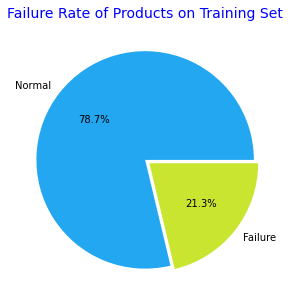

In [6]:
colors = ["#22a7f0","#c9e52f"]
labels = ['Normal', 'Failure']
explode = [0,0.05]

print(df_train_full.failure.value_counts())
           
plt.figure(figsize = (5,5))
plt.pie(df_train_full.failure.value_counts(),explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Failure Rate of Products on Training Set", color = 'blue',fontsize = 14)

### Ratio of Nan Values
There is a lot of missing value. We will deal with them later.

In [7]:
cm = sns.light_palette("yellow", as_cmap=True)
pd.DataFrame({"NaN Count": df_train_full.isna().sum(),
              "NaN Ratio": df_train_full.isna().sum()/len(df_train_full)}).sort_values(by="NaN Count",
                                                                 ascending=False).style.background_gradient(cmap=cm)

,NaN Count,NaN Ratio
measurement_17,2284,0.085962
measurement_16,2110,0.079413
measurement_15,2009,0.075612
measurement_14,1874,0.070531
measurement_13,1774,0.066767
measurement_12,1601,0.060256
measurement_11,1468,0.055250
measurement_10,1300,0.048927
measurement_9,1227,0.046180
measurement_8,1048,0.039443


<a id="4"></a> <br>
## 2. Missing Values

In [8]:
df_train.isnull().sum()

product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
dtype: int64

<div class="alert alert-block alert-warning">
<b>Remember:</b> Null Values can be a sign of failure.
</div>

In [9]:
cols_with_missing = [col for col in df_train.columns if df_train[col].isnull().any()]
cols_with_missing

['loading',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [10]:
# new columns for missing columns
new_columns = []
for col in cols_with_missing:
    new_columns.append(f"{col}_was_missing")

print(new_columns)

['loading_was_missing', 'measurement_3_was_missing', 'measurement_4_was_missing', 'measurement_5_was_missing', 'measurement_6_was_missing', 'measurement_7_was_missing', 'measurement_8_was_missing', 'measurement_9_was_missing', 'measurement_10_was_missing', 'measurement_11_was_missing', 'measurement_12_was_missing', 'measurement_13_was_missing', 'measurement_14_was_missing', 'measurement_15_was_missing', 'measurement_16_was_missing', 'measurement_17_was_missing']


In [11]:
numerical_cols = [c for c in df_train.columns if df_train[c].dtypes in ['int', 'float']]
print("Numerical Columns\n", numerical_cols)

categorical_cols = [c for c in df_train.columns if df_train[c].dtypes in ['object']]
print("\nCategorical Columns\n", categorical_cols)

Numerical Columns
 ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

Categorical Columns
 ['product_code', 'attribute_0', 'attribute_1']


In [12]:
numerical_cols += new_columns
print(numerical_cols)

['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'loading_was_missing', 'measurement_3_was_missing', 'measurement_4_was_missing', 'measurement_5_was_missing', 'measurement_6_was_missing', 'measurement_7_was_missing', 'measurement_8_was_missing', 'measurement_9_was_missing', 'measurement_10_was_missing', 'measurement_11_was_missing', 'measurement_12_was_missing', 'measurement_13_was_missing', 'measurement_14_was_missing', 'measurement_15_was_missing', 'measurement_16_was_missing', 'measurement_17_was_missing']


<a id="5"></a> <br>
# Preprocess

In [13]:
# Preprocessing for numerical data
# it was constant
numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                                        ('std_scaler', StandardScaler())
                                       ]) 


# # Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

### Apply Preprocess
When I use preprocess on kfold, preprocess can't deal with test data columns categories that training data doesn't contain. So, I make preprocess before everything. ??? 

In [14]:
def do_preprocess(df, preprocessor, train = False, shapes = False):
    for col in cols_with_missing:
        df[col + '_was_missing'] = df[col].isnull()
    
    if train==True:
        df = preprocessor.fit_transform(df)
    else:
        df = preprocessor.transform(df)
    if shapes:
        print(df.shape)
    else:
        pass
    return df

In [15]:
x_train = do_preprocess(df_train, preprocessor, train=True, shapes=True)

(26570, 47)


<a id="6"></a> <br>
## New Columns After Preprocessing

In [16]:
for c in preprocessor.named_transformers_['cat']['onehot'].categories_:
    print(c)

cat_one_hot_attribs = np.concatenate([c for c in preprocessor.named_transformers_['cat']['onehot'].categories_])
print("\nCategorical Columns:\n", cat_one_hot_attribs) 
print("\nNumerical Columns:\n", numerical_cols)

all_cols = np.concatenate((numerical_cols, cat_one_hot_attribs))
print("\nAll Columns:\n", all_cols)
print("\nAll Columns Shape:", all_cols.shape)

['A' 'B' 'C' 'D' 'E']
['material_5' 'material_7']
['material_5' 'material_6' 'material_8']

Categorical Columns:
 ['A' 'B' 'C' 'D' 'E' 'material_5' 'material_7' 'material_5' 'material_6'
 'material_8']

Numerical Columns:
 ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'loading_was_missing', 'measurement_3_was_missing', 'measurement_4_was_missing', 'measurement_5_was_missing', 'measurement_6_was_missing', 'measurement_7_was_missing', 'measurement_8_was_missing', 'measurement_9_was_missing', 'measurement_10_was_missing', 'measurement_11_was_missing', 'measurement_12_was_missing', 'measurement_13_was_missing', 'measurement_14_was_missing', 'measurement_15_was_missing', 'measurement_16

In [17]:
# Show feature importances
# code source : https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense
def plot_model_feature_importance(feature_importance_list, features, title_name='Model Feature Importance', number_of_features=10):
    """
    features_importance_list: array of features importance
    features: a array that contain columns or features names
    title_name = title of graph
    number_of_features : how many numbers of features to show on the graph
    """
    importance_df = pd.DataFrame(np.array(feature_importance_list).T, index=features)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = features
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(number_of_features)
    plt.figure(figsize=(14, 4))
    plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title(title_name)
    plt.show()
    
    return importance_df # to show the dataframe

# importance_df = plot_model_feature_importance(feature_importances, all_cols, number_of_features=20)

<a id="26"></a> <br>
# Blending

<a id="27"></a> <br>
# Create Folds

In [18]:
# df_train_full is for kfold

df_train_full = df_train_full.copy()
df_train_full["kfold"] = -1 

df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,kfold
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,-1
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,-1
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,-1
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,-1
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,-1


In [19]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_train_full)):
    df_train_full.loc[valid_indicies, "kfold"] = fold

df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,kfold
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,1
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,3
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,3
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,1
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,2


In [20]:
# to save id's
df_train_full['id'] = df_train_full.index 
df_train_full = df_train_full.reset_index(drop=True)
df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,kfold,id
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,1,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,3,1
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,3,2
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,1,3
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,2,4


# Train and Make Predictions

# LogisticRegression

In [21]:
final_test_predictions = []
final_valid_predictions = {}
scores = []  # roc auc scores

for fold in range(5): #5
    x_train = df_train_full[df_train_full.kfold != fold].reset_index(drop=True)
    x_val = df_train_full[df_train_full.kfold == fold].reset_index(drop=True)
    x_test = df_test.copy()
    
    valid_ids = x_val['id'].values.tolist()
#     print(valid_ids)
    
    y_train = x_train.failure
    y_val = x_val.failure
    
    # to drop target colum
    x_train = x_train.drop(['id','failure'], axis=1)
    x_val = x_val.drop(['id','failure'], axis=1)
#     print(x_train.head())
    
    #preprocess
    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])
    
    x_train = do_preprocess(x_train, preprocessor, train=True)
    x_val = do_preprocess(x_val, preprocessor, train=False)
    x_test = do_preprocess(x_test, preprocessor, train=False)
    
    #select model
    model = LogisticRegression()
    
    # train and predict
    model.fit(x_train, y_train)

    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]    
        
    # save test and validation predictions on a list and a dict
    final_test_predictions.append(y_test_pred)
    final_valid_predictions.update(dict(zip(valid_ids, y_val_pred)))
    

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_1"]
final_valid_predictions.to_csv("train_pred_1.csv", index=False)

submission = pd.DataFrame({'id': df_test.index, 'pred_1': y_test_pred})
submission['pred_1'] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission.to_csv('test_pred_1.csv', index=False)
submission

auc = 0.58801
auc = 0.59113
auc = 0.59082
auc = 0.57946
auc = 0.58035
0.5859537286903322 0.005063476467222167


,id,pred_1
0,26570,0.214658
1,26571,0.160740
2,26572,0.189358
3,26573,0.191554
4,26574,0.347651
...,...,...
20770,47340,0.224610
20771,47341,0.166526
20772,47342,0.167137
20773,47343,0.229548


In [22]:
final_valid_predictions.head()

,id,pred_1
0,6,0.255786
1,17,0.141560
2,29,0.159247
3,30,0.385853
4,34,0.160467


In [23]:
final_valid_predictions.shape

(26570, 2)

# XGBoost

In [24]:
final_test_predictions = []
final_valid_predictions = {}
scores = []  # roc auc scores

for fold in range(5): #5
    x_train =  df_train_full[df_train_full.kfold != fold].reset_index(drop=True)
    x_val = df_train_full[df_train_full.kfold == fold].reset_index(drop=True)
    x_test = df_test.copy()
    
    valid_ids = x_val.id.values.tolist()
#     print(valid_ids)
    
    y_train = x_train.failure
    y_val = x_val.failure
    
    # to drop target colum
    x_train = x_train.drop(['id','failure'], axis=1)
    x_val = x_val.drop(['id','failure'], axis=1)
#     print(x_train.head())
    
    #preprocess
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])
    
    x_train = do_preprocess(x_train, preprocessor, train=True)
    x_val = do_preprocess(x_val, preprocessor, train=False)
    x_test = do_preprocess(x_test, preprocessor, train=False)
    
    #select model
    model = XGBClassifier()
    
    # train and predict
    model.fit(x_train, y_train)

    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]    
        
    # save test and validation predictions on a list and a dict
    final_test_predictions.append(y_test_pred)
    final_valid_predictions.update(dict(zip(valid_ids, y_val_pred)))
    

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_2"]
final_valid_predictions.to_csv("train_pred_2.csv", index=False)

submission = pd.DataFrame({'id': df_test.index, 'pred_2': y_test_pred})
submission['pred_2'] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission.to_csv('test_pred_2.csv', index=False)
submission

auc = 0.55216
auc = 0.54565
auc = 0.55106
auc = 0.53795
auc = 0.54378
0.5461214090698647 0.005162464123634338


,id,pred_2
0,26570,0.290344
1,26571,0.191652
2,26572,0.156164
3,26573,0.163855
4,26574,0.269452
...,...,...
20770,47340,0.195577
20771,47341,0.087028
20772,47342,0.095708
20773,47343,0.170941


# CatBoostClassifier

In [25]:
final_test_predictions = []
final_valid_predictions = {}
scores = []  # roc auc scores

for fold in range(5): #5
    x_train =  df_train_full[df_train_full.kfold != fold].reset_index(drop=True)
    x_val = df_train_full[df_train_full.kfold == fold].reset_index(drop=True)
    x_test = df_test.copy()
    
    valid_ids = x_val.id.values.tolist()
#     print(valid_ids)
    
    y_train = x_train.failure
    y_val = x_val.failure
    
    # to drop target colum
    x_train = x_train.drop(['id','failure'], axis=1)
    x_val = x_val.drop(['id','failure'], axis=1)
#     print(x_train.head())
    
    #preprocess
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])
    
    x_train = do_preprocess(x_train, preprocessor, train=True)
    x_val = do_preprocess(x_val, preprocessor, train=False)
    x_test = do_preprocess(x_test, preprocessor, train=False)
    
    #select model
    model = CatBoostClassifier(iterations=5,verbose=5)
    
    # train and predict
    model.fit(x_train, y_train)

    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]    
        
    # save test and validation predictions on a list and a dict
    final_test_predictions.append(y_test_pred)
    final_valid_predictions.update(dict(zip(valid_ids, y_val_pred)))
    

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_3"]
final_valid_predictions.to_csv("train_pred_3.csv", index=False)

submission = pd.DataFrame({'id': df_test.index, 'pred_3': y_test_pred})
submission['pred_3'] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission.to_csv('test_pred_3.csv', index=False)
submission

Learning rate set to 0.5
0:	learn: 0.5558310	total: 63.7ms	remaining: 255ms
4:	learn: 0.5090934	total: 98.7ms	remaining: 0us
auc = 0.57720
Learning rate set to 0.5
0:	learn: 0.5558079	total: 10.8ms	remaining: 43.1ms
4:	learn: 0.5033736	total: 54.3ms	remaining: 0us
auc = 0.57413
Learning rate set to 0.5
0:	learn: 0.5500531	total: 10.2ms	remaining: 40.9ms
4:	learn: 0.5035917	total: 53.5ms	remaining: 0us
auc = 0.57671
Learning rate set to 0.5
0:	learn: 0.5522010	total: 9.38ms	remaining: 37.5ms
4:	learn: 0.5053948	total: 45ms	remaining: 0us
auc = 0.57157
Learning rate set to 0.5
0:	learn: 0.5495418	total: 8.38ms	remaining: 33.5ms
4:	learn: 0.5021499	total: 44.9ms	remaining: 0us
auc = 0.57926
0.575774200241235 0.0026635589020334157


,id,pred_3
0,26570,0.203895
1,26571,0.167353
2,26572,0.187295
3,26573,0.185616
4,26574,0.287583
...,...,...
20770,47340,0.264605
20771,47341,0.167281
20772,47342,0.171623
20773,47343,0.214869


### LGBMClassifier

In [26]:
final_test_predictions = []
final_valid_predictions = {}
scores = []  # roc auc scores

for fold in range(5): #5
    x_train =  df_train_full[df_train_full.kfold != fold].reset_index(drop=True)
    x_val = df_train_full[df_train_full.kfold == fold].reset_index(drop=True)
    x_test = df_test.copy()
    
    valid_ids = x_val.id.values.tolist()
#     print(valid_ids)
    
    y_train = x_train.failure
    y_val = x_val.failure
    
    # to drop target colum
    x_train = x_train.drop(['id','failure'], axis=1)
    x_val = x_val.drop(['id','failure'], axis=1)
#     print(x_train.head())
    
    #preprocess
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])
    
    x_train = do_preprocess(x_train, preprocessor, train=True)
    x_val = do_preprocess(x_val, preprocessor, train=False)
    x_test = do_preprocess(x_test, preprocessor, train=False)
    
    #select model
    model = LGBMClassifier()
    
    # train and predict
    model.fit(x_train, y_train)

    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]    
        
    # save test and validation predictions on a list and a dict
    final_test_predictions.append(y_test_pred)
    final_valid_predictions.update(dict(zip(valid_ids, y_val_pred)))
    

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_4"]
final_valid_predictions.to_csv("train_pred_4.csv", index=False)

submission = pd.DataFrame({'id': df_test.index, 'pred_4': y_test_pred})
submission['pred_4'] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission.to_csv('test_pred_4.csv', index=False)
submission

auc = 0.57329
auc = 0.56253
auc = 0.56796
auc = 0.55435
auc = 0.55835
0.5632954185963422 0.006731548777471651


,id,pred_4
0,26570,0.230816
1,26571,0.181400
2,26572,0.162344
3,26573,0.193869
4,26574,0.253739
...,...,...
20770,47340,0.198539
20771,47341,0.124957
20772,47342,0.115986
20773,47343,0.213511


# Merge New Sets

In [27]:
df1 = pd.read_csv("train_pred_1.csv")
df2 = pd.read_csv("train_pred_2.csv")
df3 = pd.read_csv("train_pred_3.csv")
df4 = pd.read_csv("train_pred_4.csv")

df_test1 = pd.read_csv("test_pred_1.csv")
df_test2 = pd.read_csv("test_pred_2.csv")
df_test3 = pd.read_csv("test_pred_3.csv")
df_test4 = pd.read_csv("test_pred_4.csv")

df = df_train_full.copy()

df = df.merge(df1, on="id", how="left")
df = df.merge(df2, on="id", how="left")
df = df.merge(df3, on="id", how="left")
df = df.merge(df4, on="id", how="left")

df_test = df_test.merge(df_test1, on="id", how="left")
df_test = df_test.merge(df_test2, on="id", how="left")
df_test = df_test.merge(df_test3, on="id", how="left")
df_test = df_test.merge(df_test4, on="id", how="left")

print(df.columns)

df.head()

Index(['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2',
       'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2',
       'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
       'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
       'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
       'measurement_15', 'measurement_16', 'measurement_17', 'failure',
       'kfold', 'id', 'pred_1', 'pred_2', 'pred_3', 'pred_4'],
      dtype='object')


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_15,measurement_16,measurement_17,failure,kfold,id,pred_1,pred_2,pred_3,pred_4
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,13.034,14.684,764.100,0,1,0,0.177412,0.054920,0.137021,0.162429
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,14.395,15.631,682.057,0,3,1,0.161418,0.082976,0.146854,0.119400
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,14.094,17.946,663.376,0,3,2,0.162068,0.091706,0.101601,0.124243
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,16.154,17.172,826.282,0,1,3,0.201639,0.135273,0.206713,0.171686
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,13.153,16.412,579.885,0,2,4,0.288443,0.226917,0.312349,0.191212


In [28]:
df_test.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,pred_1,pred_2,pred_3,pred_4
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,13.772,13.659,16.825,13.742,17.710,634.612,0.214658,0.290344,0.203895,0.230816
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,12.473,17.468,16.708,14.776,14.102,537.037,0.160740,0.191652,0.167353,0.181400
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,10.907,13.363,15.737,17.065,16.021,658.995,0.189358,0.156164,0.187295,0.162344
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,10.933,15.501,15.667,12.620,16.111,594.301,0.191554,0.163855,0.185616,0.193869
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,11.941,16.070,16.183,13.324,17.150,801.044,0.347651,0.269452,0.287583,0.253739


In [29]:
df.columns

Index(['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2',
       'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2',
       'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
       'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
       'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
       'measurement_15', 'measurement_16', 'measurement_17', 'failure',
       'kfold', 'id', 'pred_1', 'pred_2', 'pred_3', 'pred_4'],
      dtype='object')

# Blending Results

In [30]:
useful_features = ["pred_1", "pred_2", "pred_3", "pred_4"]
df_test = df_test[useful_features]

final_predictions = []
scores = []

for fold in range(5):
    x_train =  df[df.kfold != fold]
    x_val = df[df.kfold == fold]
    x_test = df_test.copy()

    y_train = x_train.failure
    y_val = x_val.failure
    
    x_train = x_train[useful_features]
    x_val = x_val[useful_features]
    
    # train model
    model = LogisticRegression()
    model.fit(x_train, y_train)
    
    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]  
    
    preds_valid = model.predict(x_val)
    test_preds = model.predict(x_test)
    
    final_predictions.append(y_test_pred)
    

print(np.mean(scores), np.std(scores))

auc = 0.58805
auc = 0.59006
auc = 0.59190
auc = 0.57895
auc = 0.58218
0.5862273735221761 0.004886289117811889


<a id="30"></a> <br>
# Submission

In [31]:
sample_submission = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv')
sample_submission.head()

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,0.0


In [32]:
sample_submission.failure = np.mean(np.column_stack(final_predictions), axis=1)
sample_submission.to_csv("submission.csv", index=False)
sample_submission

,id,failure
0,26570,0.210967
1,26571,0.170879
2,26572,0.187356
3,26573,0.189504
4,26574,0.319405
...,...,...
20770,47340,0.224227
20771,47341,0.169188
20772,47342,0.170146
20773,47343,0.217346
